In [347]:
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.patches as patches
import glob
from matplotlib.colors import Normalize


## Load in data

In [6]:
data = pd.read_csv('meta_pcs.csv').dropna(subset=['PC1','PC2'])

In [8]:
# Don't rerun - takes a while!
# kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data[['PC1', 'PC2']].values)
# log_density = kde.score_samples(data[['PC1','PC2']].values)
# data['PC1_PC2_density'] = np.exp(log_density)

# data.to_csv('meta_pcs_density.csv')

In [54]:
data_dens = pd.read_csv('meta_pcs_density.csv')

## Categorical sampliing

### IDs for each center

In [87]:
plink_header=['X1','X2','Clust']
data_dens[['id','id','assessment_center']].to_csv('../subsampling/ids_assessment_center.tsv',index=False,sep="\t",header=plink_header)

In [88]:
## WB only
filtered_rows_WB = data_dens[data_dens['ethnic_background']=='British']
filtered_rows_WB[['id','id','assessment_center']].to_csv('../subsampling/ids_assessment_center_WB.tsv',index=False,sep="\t",header=plink_header)

### IDs for birth country comparison (mainland UK)

In [89]:
countries_keep = ['England','Scotland','Wales']
filtered_rows = data_dens[data_dens['birth_UKelsewhere'].isin(countries_keep)]
filtered_rows[['id','id','birth_UKelsewhere']].to_csv('../subsampling/ids_country_UKmainland.tsv',index=False,sep="\t",header=plink_header)

In [91]:
## WB only
filtered_rows_WB = filtered_rows[filtered_rows['ethnic_background']=='British']
filtered_rows_WB[['id','id','birth_UKelsewhere']].to_csv('../subsampling/ids_country_UKmainland_WB.tsv',index=False,sep="\t",header=plink_header)

## Distance-based sampling

## PCA Space

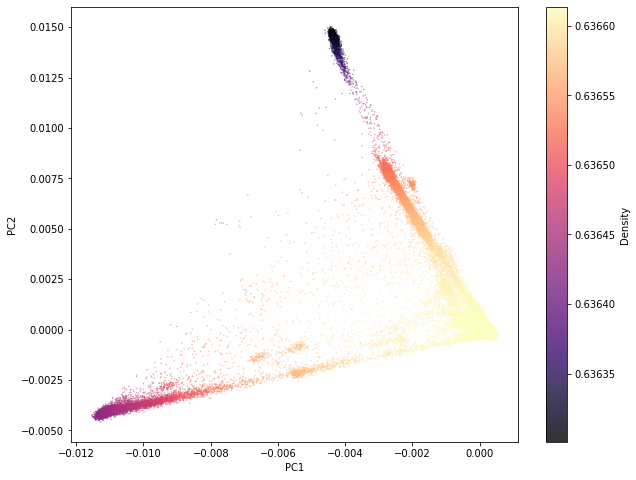

In [100]:
# plot density in 2D PC space
plt.figure(figsize=(10,8))
scatter = plt.scatter(x=data_dens['PC1'],y=data_dens['PC2'],c=data_dens['PC1_PC2_density'],cmap='magma',alpha=0.8,s=0.1)
cbar = plt.colorbar(scatter, label='Density')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

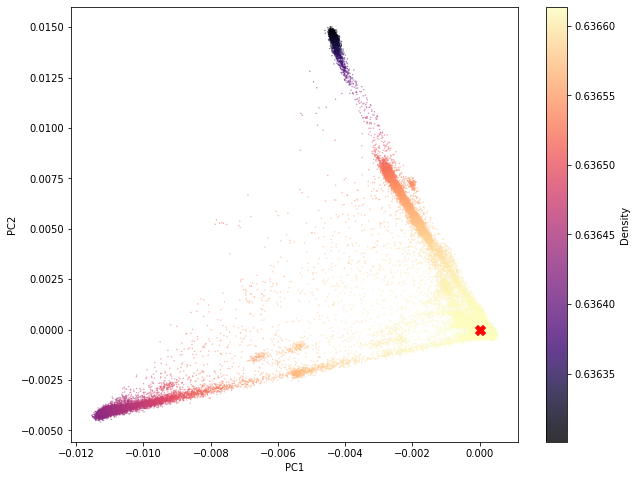

In [103]:
# calculate centroid and plot
mean_pc1 = np.mean(data_dens['PC1'])
mean_pc2 = np.mean(data_dens['PC2'])

plt.figure(figsize=(10,8))
scatter = plt.scatter(x=data_dens['PC1'],y=data_dens['PC2'],c=data_dens['PC1_PC2_density'],cmap='magma',alpha=0.8,s=0.1)
cbar = plt.colorbar(scatter, label='Density')
plt.xlabel('PC1')
plt.ylabel('PC2')

# add centroid
plt.scatter(mean_pc1,mean_pc2,c='red',marker='X',s=100)
plt.show()

In [129]:
evals = pd.read_csv('../pca/results/ukb_pca_plink2.eigenval',delim_whitespace=True,header=None)

### Repeat - scaling pcs by sqrt(eigenvalue)

In [126]:
# scale by eigenvalues
data_weights_pca = data_dens[['id','PC1','PC2','PC1_PC2_density']]
data_weights_pca['PC1_s'] = data_weights_pca['PC1']/np.sqrt(evals[0][0])
data_weights_pca['PC2_s'] = data_weights_pca['PC2']/np.sqrt(evals[0][1])
centroid_s = np.array([np.mean(data_weights_pca['PC1_s']),np.mean(data_weights_pca['PC2_s'])])
data_weights_pca['distance_centroid'] = np.linalg.norm(data_weights_pca[['PC1_s','PC2_s']].values - centroid_s, axis = 1)

<ipython-input-126-7b6cc2c4129f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_weights_pca['PC1_s'] = data_weights_pca['PC1']/np.sqrt(evals[0][0])
<ipython-input-126-7b6cc2c4129f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_weights_pca['PC2_s'] = data_weights_pca['PC2']/np.sqrt(evals[0][1])
<ipython-input-126-7b6cc2c4129f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

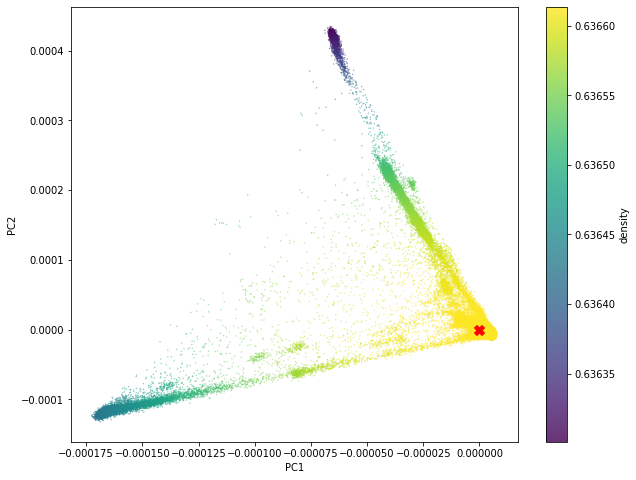

In [138]:
plt.figure(figsize=(10,8))
scatter = plt.scatter(x=data_weights_pca['PC1_s'],y=data_weights_pca['PC2_s'],c=data_weights_pca['PC1_PC2_density'],cmap='viridis',alpha=0.8,s=0.1)
cbar = plt.colorbar(scatter, label='density')
plt.xlabel('PC1')
plt.ylabel('PC2')

# add centroid
plt.scatter(centroid_s[0],centroid_s[1],c='red',marker='X',s=100)
plt.show()

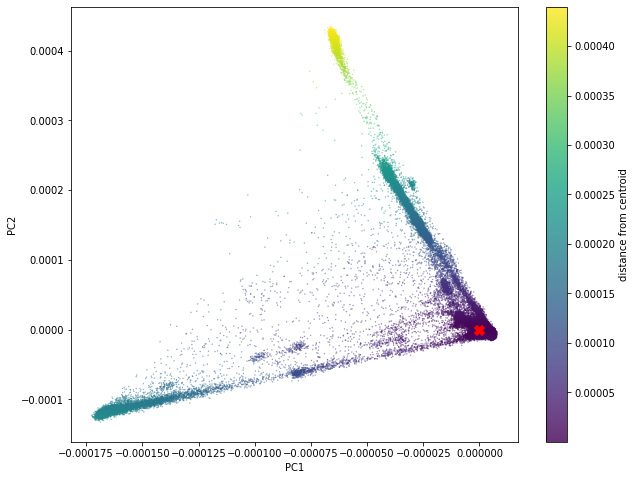

In [128]:
plt.figure(figsize=(10,8))
scatter = plt.scatter(x=data_weights_pca['PC1_s'],y=data_weights_pca['PC2_s'],c=data_weights_pca['distance_centroid'],cmap='viridis',alpha=0.8,s=0.1)
cbar = plt.colorbar(scatter, label='distance from centroid')
plt.xlabel('PC1')
plt.ylabel('PC2')

# add centroid
plt.scatter(centroid_s[0],centroid_s[1],c='red',marker='X',s=100)
plt.show()

## Generate PCA-based weights and samples

In [132]:
sorted_df = data_weights_pca.sort_values(by='distance_centroid')
closest_10k = sorted_df['id'].head(10000).tolist()
df1 = pd.DataFrame({'X1':closest_10k,'X2':closest_10k,'Clust':['closest_10k']*10000})
df1.to_csv('ids_closest_10k.tsv',sep='\t',index=False)

<ipython-input-137-6b49fa75eb9a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_weights_pca['closest_10k'] = data_weights_pca['id'].isin(closest_10k)


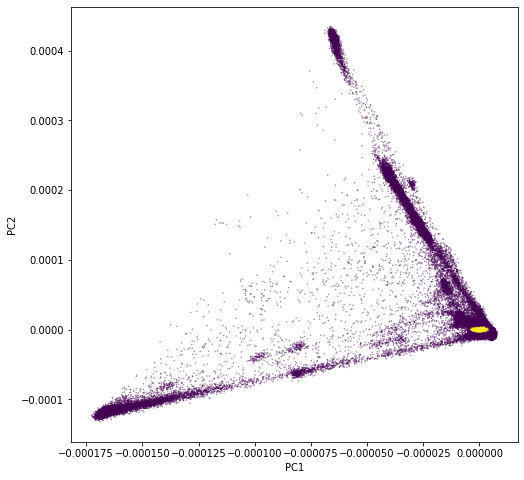

In [137]:
data_weights_pca['closest_10k'] = data_weights_pca['id'].isin(closest_10k)
plt.figure(figsize=(8,8))
scatter = plt.scatter(x=data_weights_pca['PC1_s'],y=data_weights_pca['PC2_s'],c=data_weights_pca['closest_10k'],alpha=0.8,s=0.1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [106]:
def gaussian_2d(x, y, mu_x, mu_y, sigma_x, sigma_y):
    return (1 / (2 * np.pi * sigma_x * sigma_y)) * np.exp(
        -((x - mu_x)**2 / (2 * sigma_x**2) + (y - mu_y)**2 / (2 * sigma_y**2))
    )

In [141]:
sd_pc1 = np.std(data_weights_pca['PC1_s'])
sd_pc2 = np.std(data_weights_pca['PC2_s'])

In [318]:
print(sd_pc1)
print(sd_pc2)

2.34415214907042e-05
4.533033185117183e-05


/Users/maggiesteiner/anaconda2/envs/python_39/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


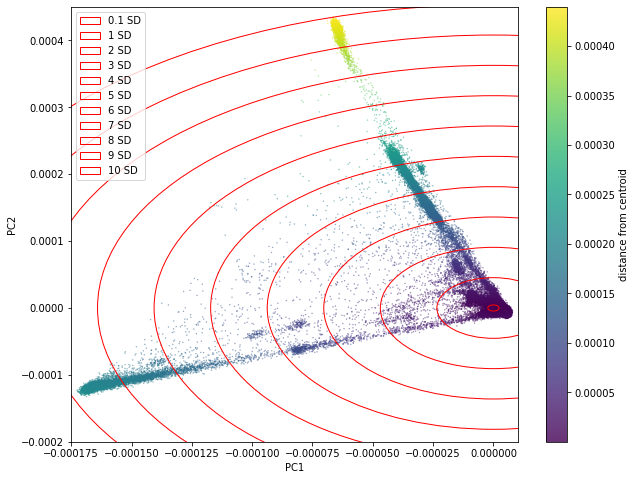

In [280]:
plt.figure(figsize=(10,8))
scatter = plt.scatter(x=data_weights_pca['PC1_s'],y=data_weights_pca['PC2_s'],c=data_weights_pca['distance_centroid'],cmap='viridis',alpha=0.8,s=0.1)
cbar = plt.colorbar(scatter, label='distance from centroid')
plt.xlabel('PC1')
plt.ylabel('PC2')

ellipse_temp = patches.Ellipse(centroid_s,2*0.1*sd_pc1,2*0.1*sd_pc2,edgecolor='red',facecolor='none',label=str(0.1)+" SD")
plt.gca().add_patch(ellipse_temp)
for i in np.arange(10)+1:
    ellipse_temp = patches.Ellipse(centroid_s,2*i*sd_pc1,2*i*sd_pc2,edgecolor='red',facecolor='none',label=str(i)+" SD")
    plt.gca().add_patch(ellipse_temp)
plt.xlim(-0.000175,0.00001)
plt.ylim(-0.0002,0.00045)
plt.legend()
plt.show()

In [326]:
data_weights_pca['01SD_IS'] = data_weights_pca.apply(lambda row: gaussian_2d(row['PC1_s'], row['PC2_s'], centroid_s[0], centroid_s[1], 0.1*sd_pc1, 0.1*sd_pc2), axis=1)/data_weights_pca['PC1_PC2_density']
for i in np.arange(10)+1:
    col_name = str(i)+"SD_IS"
    data_weights_pca[col_name] = data_weights_pca.apply(lambda row: gaussian_2d(row['PC1_s'], row['PC2_s'], centroid_s[0], centroid_s[1], i*sd_pc1, i*sd_pc2), axis=1)/data_weights_pca['PC1_PC2_density']
    

<ipython-input-326-a41ab7c24787>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_weights_pca['01SD_IS'] = data_weights_pca.apply(lambda row: gaussian_2d(row['PC1_s'], row['PC2_s'], centroid_s[0], centroid_s[1], 0.1*sd_pc1, 0.1*sd_pc2), axis=1)/data_weights_pca['PC1_PC2_density']
<ipython-input-326-a41ab7c24787>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_weights_pca[col_name] = data_weights_pca.apply(lambda row: gaussian_2d(row['PC1_s'], row['PC2_s'], centroid_s[0], centroid_s[1], i*sd_pc1, 

In [320]:
n=10000
seeds = np.arange(20)
for seed in seeds:
    samp_unif = data_weights_pca.sample(n=n,weights=(1/data_weights_pca['PC1_PC2_density']).replace(float('inf'),0),random_state=seed)
    df_unif = pd.DataFrame({'X1':samp_unif['id'],'X2':samp_unif['id'],'Clust':['UNIF_IS']*n})
    df_unif.to_csv('UNIF_IS_seed'+str(seed)+'_n'+str(n)+'.tsv',sep='\t',index=False)
    samp_temp = data_weights_pca.sample(n=n,weights='01SD_IS',random_state=seed)
    df_temp = pd.DataFrame({'X1':samp_temp['id'],'X2':samp_temp['id'],'Clust':['01SD_IS']*n})
    df_temp.to_csv('01SD_IS_seed'+str(seed)+'_n'+str(n)+'.tsv',sep='\t',index=False)
    for i in np.arange(10)+1:
        samp_temp = data_weights_pca.sample(n=n,weights=str(i)+'SD_IS',random_state=seed)
        df_temp = pd.DataFrame({'X1':samp_temp['id'],'X2':samp_temp['id'],'Clust':[str(i)+'SD_IS']*n})
        df_temp.to_csv(str(i)+'SD_IS_seed'+str(seed)+'_n'+str(n)+'.tsv',sep='\t',index=False)

<ipython-input-344-b0f5840c3fd7>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('magma', 11)


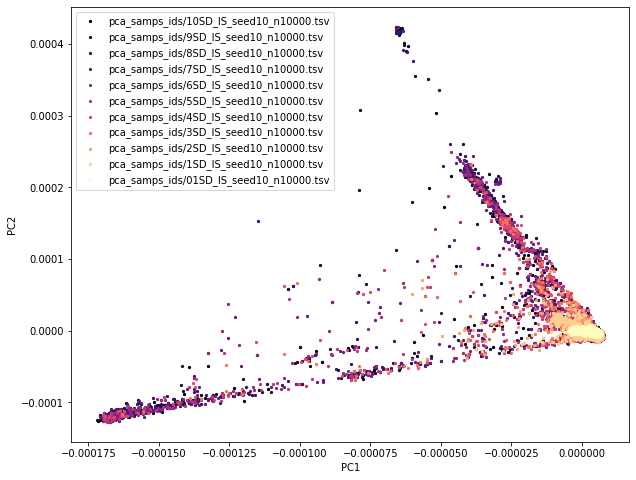

In [344]:
seed_to_plot = 10
plt.figure(figsize=(10, 8))
cmap = plt.cm.get_cmap('magma', 11)
colors = [to_hex(cmap(i)) for i in range(11)]

k=0
for i in (np.arange(10)+1)[::-1]:
    files = glob.glob('pca_samps_ids/'+str(i)+'SD_IS_seed'+str(seed_to_plot)+"*")
    dfs = {file: pd.read_csv(file,sep="\t") for file in files}

    for df in dfs.values():
        if df.columns[0] != 'ID':
            df.rename(columns={df.columns[0]: 'id'}, inplace=True)
    merged_dataframes = {file: pd.merge(data_weights_pca, df, on='id') for file, df in dfs.items()}
    
    for file, merged_df in merged_dataframes.items():
        plt.scatter(merged_df['PC1_s'], merged_df['PC2_s'], label=file,s=5,color=colors[k])
        k+=1



files = glob.glob('pca_samps_ids/01SD_IS_seed'+str(seed_to_plot)+"*")
dfs = {file: pd.read_csv(file,sep="\t") for file in files}

for df in dfs.values():
    if df.columns[0] != 'ID':
        df.rename(columns={df.columns[0]: 'id'}, inplace=True)
merged_dataframes = {file: pd.merge(data_weights_pca, df, on='id') for file, df in dfs.items()}
for file, merged_df in merged_dataframes.items():
    plt.scatter(merged_df['PC1_s'], merged_df['PC2_s'], label=file,s=5,color=colors[k])



# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

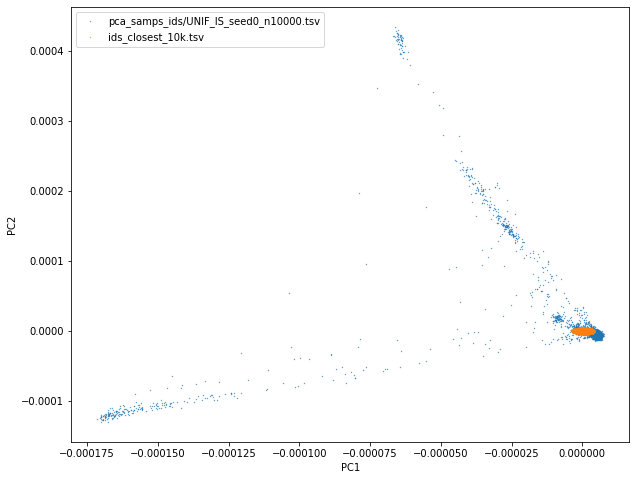

In [322]:
seed_to_plot = 0
plt.figure(figsize=(10, 8))

files = glob.glob('pca_samps_ids/UNIF*seed'+str(seed_to_plot)+'*')
dfs = {file: pd.read_csv(file,sep="\t") for file in files}

for df in dfs.values():
    if df.columns[0] != 'ID':
        df.rename(columns={df.columns[0]: 'id'}, inplace=True)
merged_dataframes = {file: pd.merge(data_weights_pca, df, on='id') for file, df in dfs.items()}
for file, merged_df in merged_dataframes.items():
    plt.scatter(merged_df['PC1_s'], merged_df['PC2_s'], label=file,s=0.1)   

files = ['ids_closest_10k.tsv']
dfs = {file: pd.read_csv(file,sep="\t") for file in files}
for df in dfs.values():
    if df.columns[0] != 'ID':
        df.rename(columns={df.columns[0]: 'id'}, inplace=True)
merged_dataframes = {file: pd.merge(data_weights_pca, df, on='id') for file, df in dfs.items()}
for file, merged_df in merged_dataframes.items():
        plt.scatter(merged_df['PC1_s'], merged_df['PC2_s'], label=file,s=0.1)   


# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

## Geographic space

In [221]:
### add in geographic space density
# Don't rerun - takes a while!
# data_dens_geo=data_dens[(data_dens['birth_east_coord'].notna()) & (data_dens['birth_north_coord'].notna())]
# kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data_dens_geo[['birth_east_coord', 'birth_north_coord']].values)
# log_density = kde.score_samples(data_dens_geo[['birth_east_coord','birth_north_coord']].values)
# data_dens_geo['birth_coord_density'] = np.exp(log_density)
# data_dens_geo.to_csv('meta_pcs_density_geo.csv')

<ipython-input-221-e3c19a6e09bb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dens_geo['birth_coord_density'] = np.exp(log_density)


In [222]:
data_geo_dens = pd.read_csv('meta_pcs_density_geo.csv')

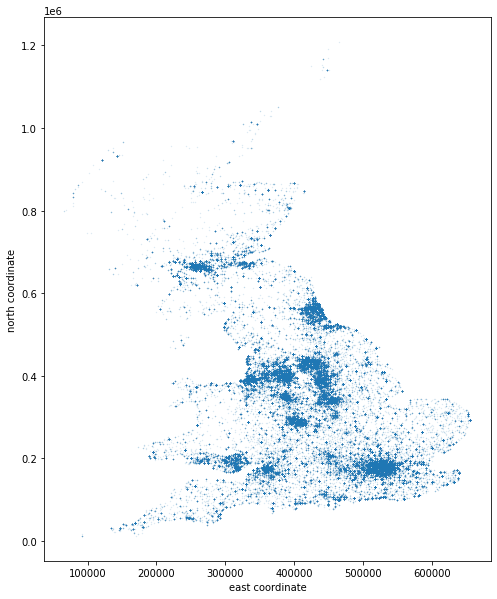

In [346]:
plt.figure(figsize=(8,10))
scatter = plt.scatter(x=data_geo_dens['birth_east_coord'],y=data_geo_dens['birth_north_coord'],alpha=0.2,s=0.1)
plt.xlabel('east coordinate')
plt.ylabel('north coordinate')

plt.show()

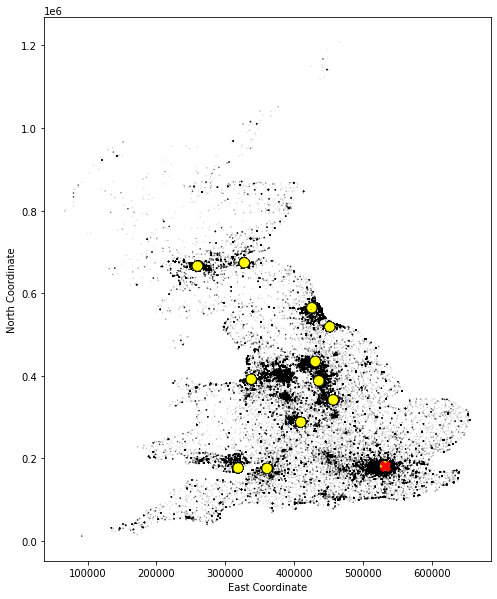

In [289]:
density_threshold = 0.005

plt.figure(figsize=(8, 10))
scatter = plt.scatter(
    x=data_geo_dens['birth_east_coord'],
    y=data_geo_dens['birth_north_coord'],
    c=np.where(data_geo_dens['birth_coord_density'] > density_threshold, 'yellow', "black"),
    alpha=np.where(data_geo_dens['birth_coord_density'] > density_threshold, 1, 0.1),
    s=np.where(data_geo_dens['birth_coord_density'] > density_threshold, 100, 1),
    edgecolors=np.where(data_geo_dens['birth_coord_density'] > density_threshold, 'black', 'none'), linewidths=0.5
)

plt.xlabel('East Coordinate')
plt.ylabel('North Coordinate')

plt.scatter(532000,182000,s=100,c='red',marker='X')

plt.show()


In [290]:
barts_coords=[532000,182000]

In [294]:
data_geo_dens['distance_barts'] = np.linalg.norm(data_geo_dens[['birth_east_coord','birth_north_coord']].values - barts_coords, axis = 1)


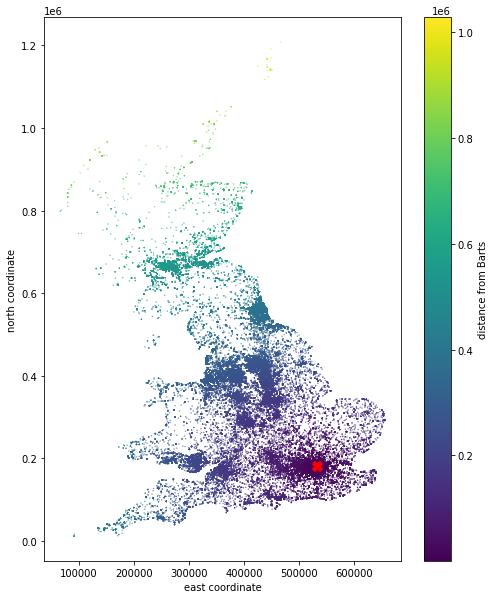

In [342]:
plt.figure(figsize=(8,10))
scatter = plt.scatter(x=data_geo_dens['birth_east_coord'],y=data_geo_dens['birth_north_coord'],c=data_geo_dens['distance_barts'],alpha=1,s=0.1)
plt.xlabel('east coordinate')
plt.ylabel('north coordinate')
plt.scatter(532000,182000,s=100,c='red',marker='X')
cbar = plt.colorbar(scatter, label='distance from Barts')
plt.show()

In [304]:
sd_geo_east = np.std(data_geo_dens['birth_east_coord'])
sd_geo_north = np.std(data_geo_dens['birth_north_coord'])


In [305]:
sd_geo_north

163305.87452460348

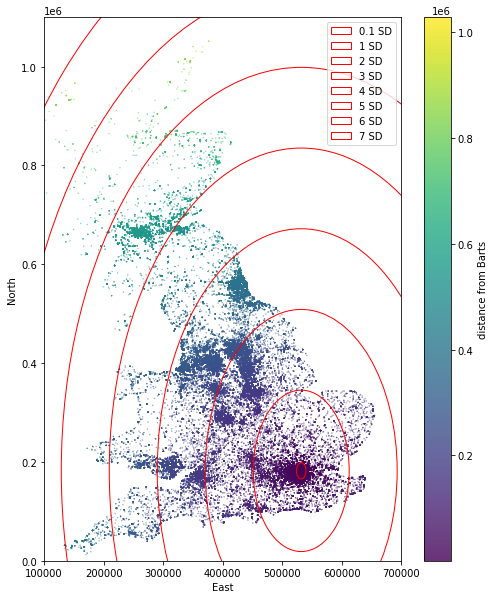

In [317]:
plt.figure(figsize=(8,10))
scatter = plt.scatter(x=data_geo_dens['birth_east_coord'],y=data_geo_dens['birth_north_coord'],c=data_geo_dens['distance_barts'],cmap='viridis',alpha=0.8,s=0.1)
cbar = plt.colorbar(scatter, label='distance from Barts')
plt.xlabel('East')
plt.ylabel('North')

ellipse_temp = patches.Ellipse(barts_coords,2*0.1*sd_geo_east,2*0.1*sd_geo_north,edgecolor='red',facecolor='none',label=str(0.1)+" SD")
plt.gca().add_patch(ellipse_temp)
for i in np.arange(7)+1:
    ellipse_temp = patches.Ellipse(barts_coords,2*i*sd_geo_east,2*i*sd_geo_north,edgecolor='red',facecolor='none',label=str(i)+" SD")
    plt.gca().add_patch(ellipse_temp)
plt.legend()
plt.xlim(100000,700000)
plt.ylim(0,1.1e6)
plt.show()

In [325]:
data_geo_dens['01SD_IS'] = data_geo_dens.apply(lambda row: gaussian_2d(row['birth_east_coord'], row['birth_north_coord'], barts_coords[0], barts_coords[1], 0.1*sd_geo_east, 0.1*sd_geo_north), axis=1)/data_geo_dens['birth_coord_density']
for i in np.arange(7)+1:
    col_name = str(i)+"SD_IS"
    data_geo_dens[col_name] = data_geo_dens.apply(lambda row: gaussian_2d(row['birth_east_coord'], row['birth_north_coord'], barts_coords[0], barts_coords[1], i*sd_geo_east, i*sd_geo_north), axis=1)/data_geo_dens['birth_coord_density']
    

In [328]:
n=10000
seeds = np.arange(20)
for seed in seeds:
    samp_unif = data_geo_dens.sample(n=n,weights=(1/data_geo_dens['birth_coord_density']).replace(float('inf'),0),random_state=seed)
    df_unif = pd.DataFrame({'X1':samp_unif['id'],'X2':samp_unif['id'],'Clust':['UNIF_IS']*n})
    df_unif.to_csv('GEO_UNIF_IS_seed'+str(seed)+'_n'+str(n)+'.tsv',sep='\t',index=False)
    samp_temp = data_geo_dens.sample(n=n,weights='01SD_IS',random_state=seed)
    df_temp = pd.DataFrame({'X1':samp_temp['id'],'X2':samp_temp['id'],'Clust':['01SD_IS']*n})
    df_temp.to_csv('GEO_01SD_IS_seed'+str(seed)+'_n'+str(n)+'.tsv',sep='\t',index=False)
    for i in np.arange(7)+1:
        samp_temp = data_geo_dens.sample(n=n,weights=str(i)+'SD_IS',random_state=seed)
        df_temp = pd.DataFrame({'X1':samp_temp['id'],'X2':samp_temp['id'],'Clust':[str(i)+'SD_IS']*n})
        df_temp.to_csv('GEO_'+str(i)+'SD_IS_seed'+str(seed)+'_n'+str(n)+'.tsv',sep='\t',index=False)

<ipython-input-348-6332e835cfa9>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('magma', 8)


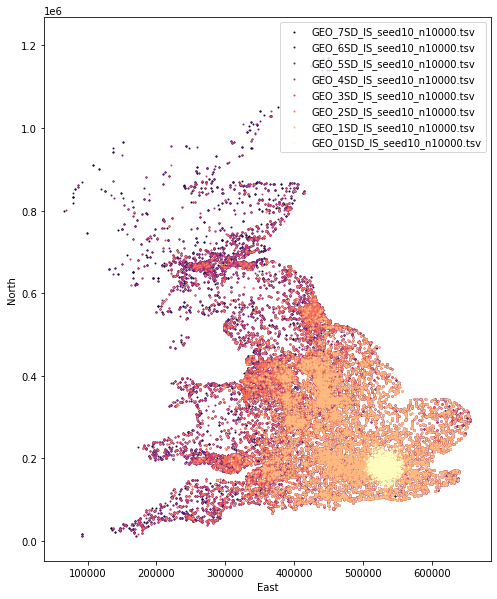

In [348]:
seed_to_plot = 10
plt.figure(figsize=(8, 10))
cmap = plt.cm.get_cmap('magma', 8)
colors = [to_hex(cmap(i)) for i in range(8)]

k=0
for i in (np.arange(7)+1)[::-1]:
    files = glob.glob('GEO_'+str(i)+'SD_IS_seed'+str(seed_to_plot)+"*")
    dfs = {file: pd.read_csv(file,sep="\t") for file in files}

    for df in dfs.values():
        if df.columns[0] != 'ID':
            df.rename(columns={df.columns[0]: 'id'}, inplace=True)
    merged_dataframes = {file: pd.merge(data_geo_dens, df, on='id') for file, df in dfs.items()}
    
    for file, merged_df in merged_dataframes.items():
        plt.scatter(merged_df['birth_east_coord'], merged_df['birth_north_coord'], label=file,s=1,color=colors[k])
        k+=1



files = glob.glob('GEO_01SD_IS_seed'+str(seed_to_plot)+"*")
dfs = {file: pd.read_csv(file,sep="\t") for file in files}

for df in dfs.values():
    if df.columns[0] != 'ID':
        df.rename(columns={df.columns[0]: 'id'}, inplace=True)
merged_dataframes = {file: pd.merge(data_geo_dens, df, on='id') for file, df in dfs.items()}
for file, merged_df in merged_dataframes.items():
    plt.scatter(merged_df['birth_east_coord'], merged_df['birth_north_coord'], label=file,s=1,color=colors[k])



# Add labels and title
plt.xlabel('East')
plt.ylabel('North')
plt.legend()
plt.show()

In [338]:
sorted_df = data_geo_dens.sort_values(by='distance_barts')
closest_10k = sorted_df['id'].head(10000).tolist()
df1 = pd.DataFrame({'X1':closest_10k,'X2':closest_10k,'Clust':['closest_10k']*10000})
df1.to_csv('GEO_ids_closest_10k.tsv',sep='\t',index=False)

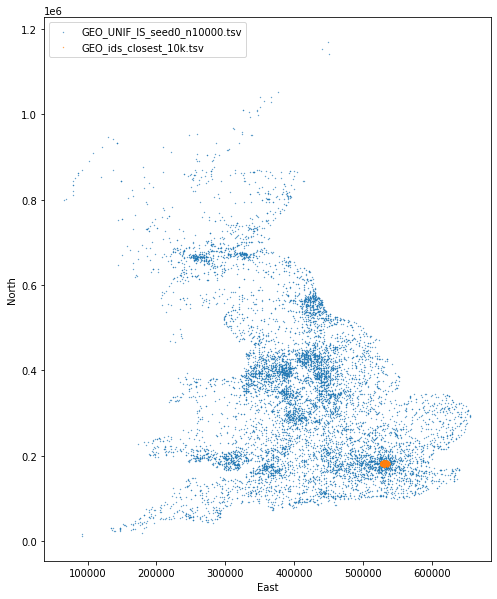

In [340]:
seed_to_plot = 0
plt.figure(figsize=(8, 10))

files = glob.glob('GEO_UNIF*seed'+str(seed_to_plot)+'*')
dfs = {file: pd.read_csv(file,sep="\t") for file in files}

for df in dfs.values():
    if df.columns[0] != 'ID':
        df.rename(columns={df.columns[0]: 'id'}, inplace=True)
merged_dataframes = {file: pd.merge(data_geo_dens, df, on='id') for file, df in dfs.items()}
for file, merged_df in merged_dataframes.items():
    plt.scatter(merged_df['birth_east_coord'], merged_df['birth_north_coord'], label=file,s=0.1)   

files = ['GEO_ids_closest_10k.tsv']
dfs = {file: pd.read_csv(file,sep="\t") for file in files}
for df in dfs.values():
    if df.columns[0] != 'ID':
        df.rename(columns={df.columns[0]: 'id'}, inplace=True)
merged_dataframes = {file: pd.merge(data_geo_dens, df, on='id') for file, df in dfs.items()}
for file, merged_df in merged_dataframes.items():
        plt.scatter(merged_df['birth_east_coord'], merged_df['birth_north_coord'], label=file,s=0.1)   


# Add labels and title
plt.xlabel('East')
plt.ylabel('North')
plt.legend()
plt.show()